In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf
from pickle import dump, load

In [4]:
def make_data(i, road_name):
    data = pd.read_csv(f"Seoul_2024/Seoul{i:02d}.csv")
    data['일자'] = pd.to_datetime(data['일자'], format='%Y%m%d')
    data.fillna(0, inplace=True)

    for i in range(24):
        if data[f"{i}시"].dtype!="float":
            data[f"{i}시"] = data[f"{i}시"].map(lambda x: float(str(x).replace(",", "").split()[0]))

    data_weather = pd.read_csv("Weather.csv")
    data_weather['날짜'] = pd.to_datetime(data_weather["날짜"])
    data_weather.fillna(0, inplace=True)

    data1 = data[data['지점명']==road_name]
    data_np = np.zeros((data1.shape[0]*24//2, 5))
    
    day_to_num = {"일":0, "월":1, "화":2, "수":3, "목":4, "금":5, "토":6}
    
    for i in range(data1.shape[0]//2):
        for j in range(24):
            # print(data1[data1["일자"]==data1["일자"].iloc[i]][f"{j}시"].iloc[0])
            data_np[i*24+j,0] = data1[f"{j}시"].iloc[i]
            data_np[i*24+j,1] = data1[data1["일자"]==data1["일자"].iloc[i]][f"{j}시"].iloc[1]
            data_np[i*24+j,2] = j
            data_np[i*24+j,3] = day_to_num[data1["요일"].iloc[i]]
            data_np[i*24+j,4] = data_weather[data_weather['날짜']==data1['일자'].iloc[i]]["강수량(mm)"].iloc[0]
    
    return data_np

In [17]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

def train_model(road_name, seq_length=12):
    data_np = []
    for i in range(9):
        data_np.append(make_data((i+1), road_name))
    data_np = np.concatenate(data_np)
    
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data_np)
    
    train_size = int(len(scaled_data) * 0.8)
    train_data = scaled_data[:train_size]
    test_data = scaled_data[train_size:]

    X_train, y_train = create_sequences(train_data, seq_length)
    X_test, y_test = create_sequences(test_data, seq_length)
    
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(seq_length, 5)),
        Dense(5)
    ])
    
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)
    
    model.save(f'models/model_{road_name}.keras')
    dump(scaler, open(f'models/scaler_{road_name}.pkl', 'wb'))
    return model, scaler

In [80]:
def train_val_model(road_name, seq_length=12):
    data_np = []
    for i in range(9):
        data_np.append(make_data((i+1), road_name))
    data_np = np.concatenate(data_np)
    
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data_np)
    
    train_size = int(len(scaled_data) * 0.8 * 0.8)
    val_size = int(len(scaled_data) * 0.8)
    train_data = scaled_data[:train_size]
    validation_data = scaled_data[train_size:val_size]
    test_data = scaled_data[val_size:]

    X_train, y_train = create_sequences(train_data, seq_length)
    X_val, y_val = create_sequences(validation_data, seq_length)
    X_test, y_test = create_sequences(test_data, seq_length)
    
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(seq_length, 5)),
        Dense(5)
    ])
    
    model.compile(optimizer='adam', loss='mse')
    hist = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=0)
    
    return model, scaler, hist

In [ ]:
data = pd.read_csv(f"Seoul01.csv")
road_list = data['지점명'].unique()

for road in road_list:
    print(road)
    train_model(road)

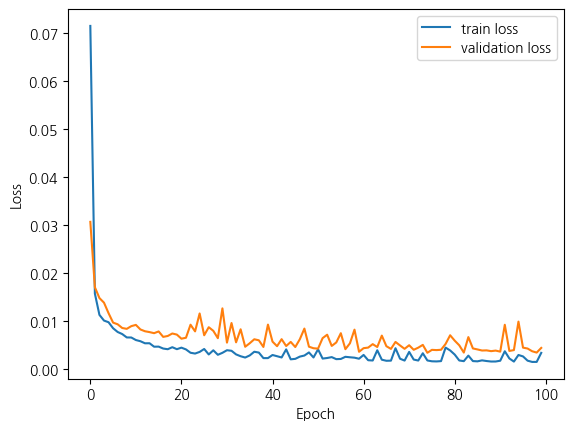

In [87]:
fig, loss_ax = plt.subplots()
loss_ax.plot(hist.history['loss'], label='train loss')
loss_ax.plot(hist.history['val_loss'], label='validation loss')
loss_ax.set_xlabel('Epoch')
loss_ax.set_ylabel('Loss')
loss_ax.legend()
plt.show()

In [94]:
data_np = []
road_name = "올림픽대로(강일IC)"
for i in range(9):
    data_np.append(make_data((i+1), road_name))
data_np = np.concatenate(data_np)

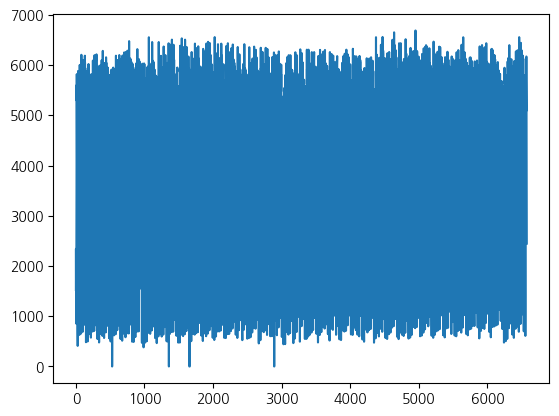

In [98]:
plt.plot(data_np[:,1])

164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


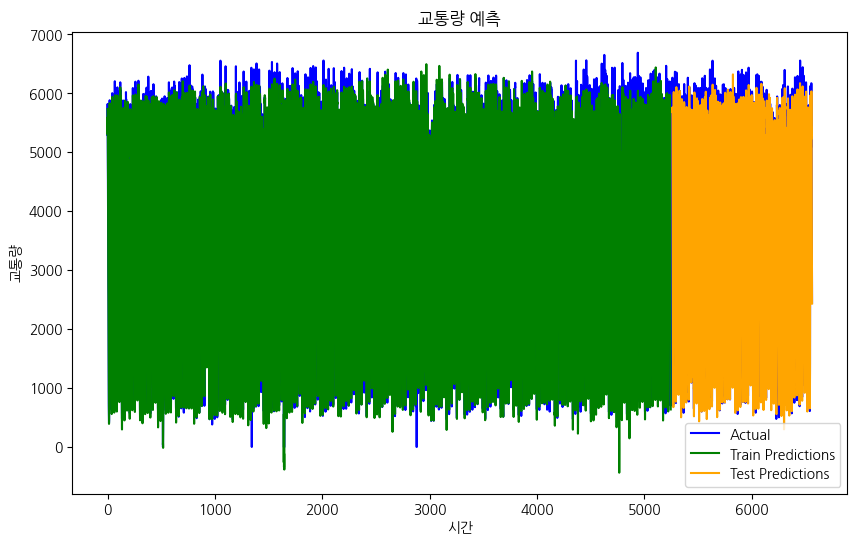

In [99]:
scaled_data = scaler.fit_transform(data_np)

train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform the predictions
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)

# Plot predictions
plt.figure(figsize=(10, 6))

# Plot actual data
plt.plot(data_np[seq_length:,1], label='Actual', color='blue')

# Plot training predictions
plt.plot(train_predictions[:,1], label='Train Predictions',color='green')

# Plot testing predictions
test_pred_index = range(seq_length+len(train_predictions), seq_length+len(train_predictions)+len(test_predictions))
plt.plot(test_pred_index, test_predictions[:,1], label='Test Predictions',color='orange')

plt.title('교통량 예측')
plt.xlabel('시간')
plt.ylabel('교통량')
plt.legend()
plt.show()

164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


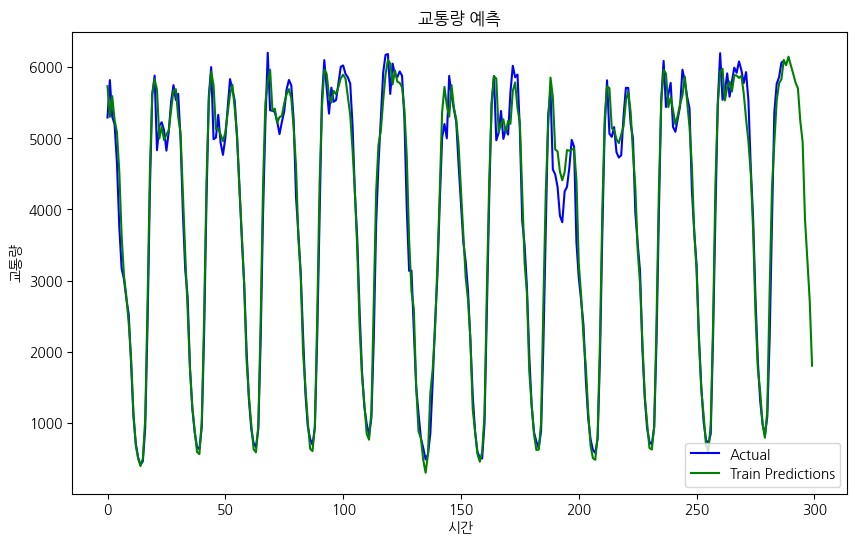

In [101]:
scaled_data = scaler.fit_transform(data_np)

train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform the predictions
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)

# Plot predictions
plt.figure(figsize=(10, 6))
train_range = 300

# Plot actual data
plt.plot(data_np[seq_length:train_range,1], label='Actual', color='blue')

# Plot training predictions
plt.plot(train_predictions[:train_range,1], label='Train Predictions',color='green')

plt.title('교통량 예측')
plt.xlabel('시간')
plt.ylabel('교통량')
plt.legend()
plt.show()

In [102]:
X_test.shape

(1304, 12, 5)

In [119]:
forecast_period = 500
forecast = []

# Use the last sequence from the test data to make predictions
last_sequence = X_test[100]
print(last_sequence[-1])
next_temp = scaler.inverse_transform(last_sequence[-1:])
time_cnt = int(next_temp[0,2])
day_cnt = int(next_temp[0,3])

for _ in range(forecast_period):
    time_cnt = time_cnt + 1
    if time_cnt==24:
        time_cnt = 0
        day_cnt = (day_cnt + 1) % 7
    
    # Reshape the sequence to match the input shape of the model
    current_sequence = last_sequence.reshape(1, seq_length, 5)
    # Predict the next value
    next_prediction = model.predict(current_sequence, verbose=0)
    next_temp = scaler.inverse_transform(next_prediction)
    next_temp[0,2] = time_cnt
    next_temp[0,3] = day_cnt
    next_temp[0,4] = 0
    next_prediction = scaler.transform(next_temp)
    # Append the prediction to the forecast list
    forecast.append(next_prediction)
    # Update the last sequence by removing the first element and appending the predicted value
    last_sequence = np.concatenate((last_sequence[1:], next_prediction))

# Inverse transform the forecasted values
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 5))

[0.79224652 0.56534091 0.82608696 0.         0.        ]


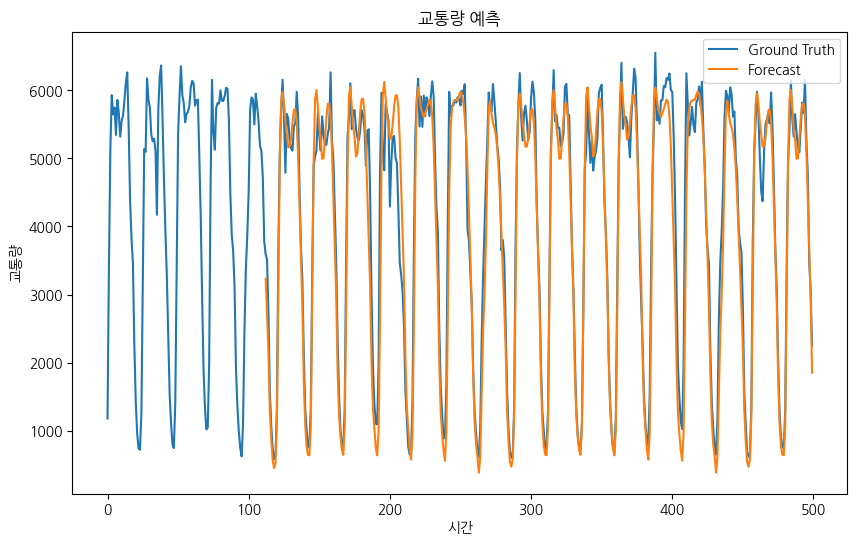

In [121]:
forecast_range = 500
plt.figure(figsize=(10, 6))
plt.plot(scaler.inverse_transform(test_data)[:forecast_range,1], label='Ground Truth')
plt.plot(range(112, forecast_range), forecast[:500-112,1], label='Forecast')
plt.title('교통량 예측')
plt.xlabel('시간')
plt.ylabel('교통량')
plt.legend()
plt.show()

In [27]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_np)

train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [28]:


seq_length = 12  # Number of time steps to look back
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, 5)),
    Dense(5)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


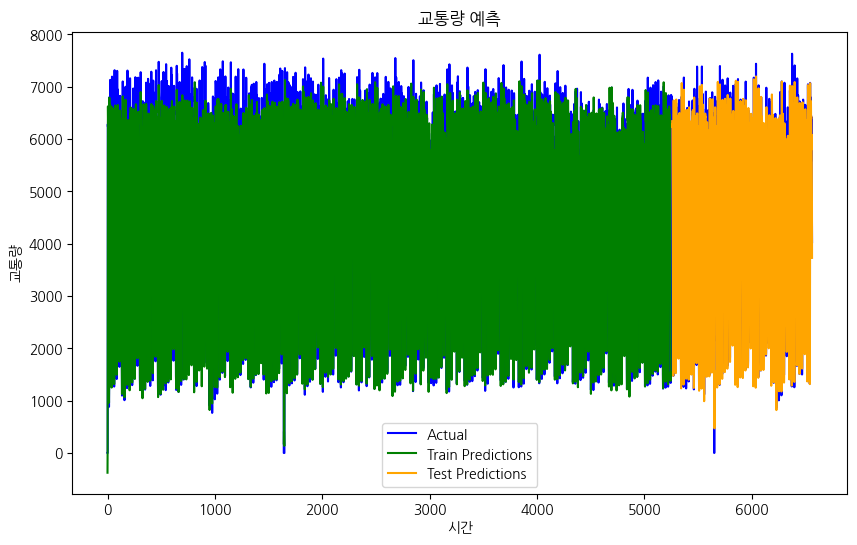

In [33]:
# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform the predictions
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)

# Plot predictions
plt.figure(figsize=(10, 6))

# Plot actual data
plt.plot(data_np[seq_length:,0], label='Actual', color='blue')

# Plot training predictions
plt.plot(train_predictions[:,0], label='Train Predictions',color='green')

# Plot testing predictions
test_pred_index = range(seq_length+len(train_predictions), seq_length+len(train_predictions)+len(test_predictions))
plt.plot(test_pred_index, test_predictions[:,0], label='Test Predictions',color='orange')

plt.title('교통량 예측')
plt.xlabel('시간')
plt.ylabel('교통량')
plt.legend()
plt.show()

In [ ]:
forecast_period = 500
forecast = []

# Use the last sequence from the test data to make predictions
last_sequence = X_test[-1]
print(last_sequence[-1])
next_temp = scaler.inverse_transform(last_sequence[-1:])
time_cnt = int(next_temp[0,2])
day_cnt = int(next_temp[0,3])

for _ in range(forecast_period):
    time_cnt = time_cnt + 1
    if time_cnt==24:
        time_cnt = 0
        day_cnt = (day_cnt + 1) % 7
    
    # Reshape the sequence to match the input shape of the model
    current_sequence = last_sequence.reshape(1, seq_length, 5)
    # Predict the next value
    next_prediction = model.predict(current_sequence)
    next_temp = scaler.inverse_transform(next_prediction)
    next_temp[0,2] = time_cnt
    next_temp[0,3] = day_cnt
    next_temp[0,4] = 0
    next_prediction = scaler.transform(next_temp)
    # Append the prediction to the forecast list
    forecast.append(next_prediction)
    # Update the last sequence by removing the first element and appending the predicted value
    last_sequence = np.concatenate((last_sequence[1:], next_prediction))

# Inverse transform the forecasted values
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 5))

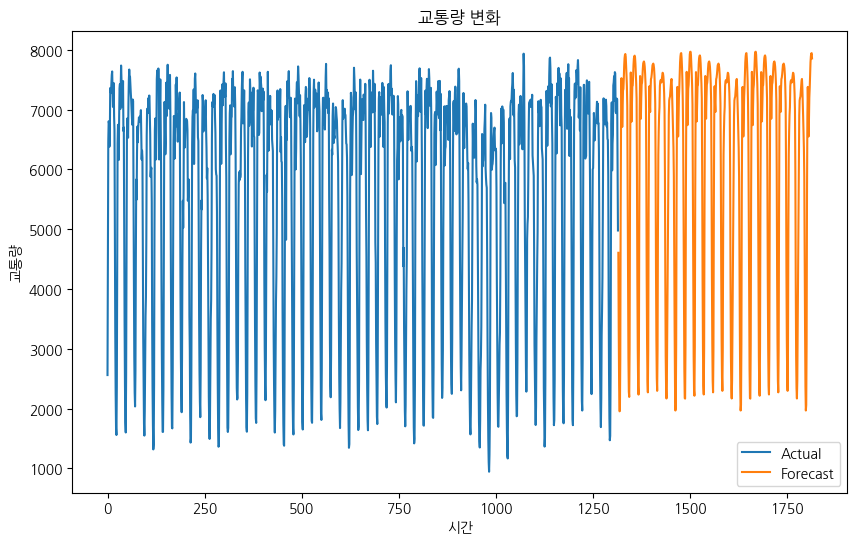

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(scaler.inverse_transform(test_data)[:,1], label='Actual')
plt.plot(range(test_data.shape[0], test_data.shape[0]+forecast.shape[0]), forecast[:,1], label='Forecast')
plt.title('교통량 변화')
plt.xlabel('시간')
plt.ylabel('교통량')
plt.legend()
plt.show()

In [36]:
from keras.models import load_model
    
model.save('seoul_model_road1.keras')

In [130]:
model1 = load_model("seoul_model.keras")

C:\Users\ilese\Downloads\radiosonde data-1 (2)\myenv\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


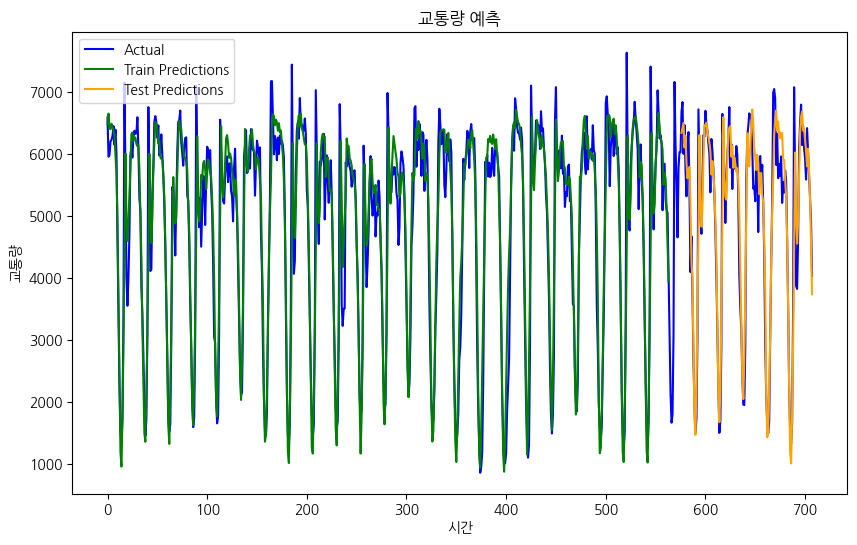

In [131]:
# Make predictions
train_predictions = model1.predict(X_train)
test_predictions = model1.predict(X_test)

# Inverse transform the predictions
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)

# Plot predictions
plt.figure(figsize=(10, 6))

# Plot actual data
plt.plot(data_np[seq_length:,0], label='Actual', color='blue')

# Plot training predictions
plt.plot(train_predictions[:,0], label='Train Predictions',color='green')

# Plot testing predictions
test_pred_index = range(seq_length+len(train_predictions), seq_length+len(train_predictions)+len(test_predictions))
plt.plot(test_pred_index, test_predictions[:,0], label='Test Predictions',color='orange')

plt.title('교통량 예측')
plt.xlabel('시간')
plt.ylabel('교통량')
plt.legend()
plt.show()

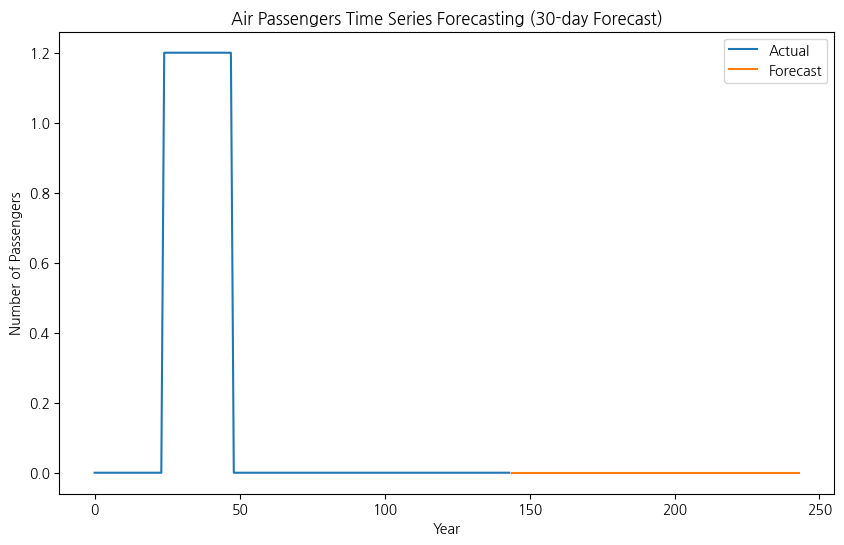

In [120]:
plt.figure(figsize=(10, 6))
plt.plot(scaler.inverse_transform(test_data)[:,4], label='Actual')
plt.plot(range(test_data.shape[0], test_data.shape[0]+forecast.shape[0]), forecast[:,4], label='Forecast')
plt.title('Air Passengers Time Series Forecasting (30-day Forecast)')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

In [31]:
import matplotlib.font_manager as fm

# 설치된 폰트 출력
font_list = [font.name for font in fm.fontManager.ttflist]

In [32]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'

In [22]:
def seoul_model_predict(given_data, road_name, seq_length=12, forecast_period=30):
    model = tf.keras.models.load_model(f'models/model_{road_name}.keras')
    scaler = load(open(f'models/scaler_{road_name}.pkl', 'rb'))
    
    scaled_data = scaler.fit_transform(given_data)
    
    forecast = []
    X_data, y_data = create_sequences(scaled_data, seq_length)
    # Use the last sequence from the test data to make predictions
    last_sequence = X_data[-1]
    print(last_sequence[-1])
    next_temp = scaler.inverse_transform(last_sequence[-1:])
    time_cnt = int(next_temp[0,2])
    day_cnt = int(next_temp[0,3])
    
    for _ in range(forecast_period):
        time_cnt = time_cnt + 1
        if time_cnt==24:
            time_cnt = 0
            day_cnt = (day_cnt + 1) % 7
        
        # Reshape the sequence to match the input shape of the model
        current_sequence = last_sequence.reshape(1, seq_length, 5)
        # Predict the next value
        next_prediction = model.predict(current_sequence)
        next_temp = scaler.inverse_transform(next_prediction)
        next_temp[0,2] = time_cnt
        next_temp[0,3] = day_cnt
        next_temp[0,4] = 0
        next_prediction = scaler.transform(next_temp)
        # Append the prediction to the forecast list
        forecast.append(next_prediction)
        # Update the last sequence by removing the first element and appending the predicted value
        last_sequence = np.concatenate((last_sequence[1:], next_prediction))
    
    # Inverse transform the forecasted values
    forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 5))

    return forecast

In [23]:
pre_data = make_data(1, "올림픽대로(강일IC)")
res_data = seoul_model_predict(pre_data, "올림픽대로(강일IC)")

[0.40638234 0.53454314 0.95652174 0.5        0.        ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31